In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/ca_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

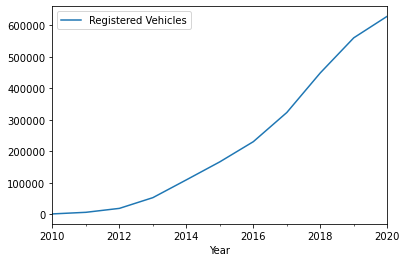

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Registered Vehicles'], ascending = True)
df = df.astype(float)

## **RESAMPLING

            Registered Vehicles
Year                           
2010-01-03              18356.0
2010-01-10              18356.0
2010-01-17              18356.0
2010-01-24              18356.0
2010-01-31              18356.0


,Registered Vehicles
Year,
2010-01-03,18356.0
2010-01-10,18356.0
2010-01-17,18356.0
2010-01-24,18356.0
2010-01-31,18356.0
...,...
2019-12-08,322762.0
2019-12-15,322762.0
2019-12-22,322762.0


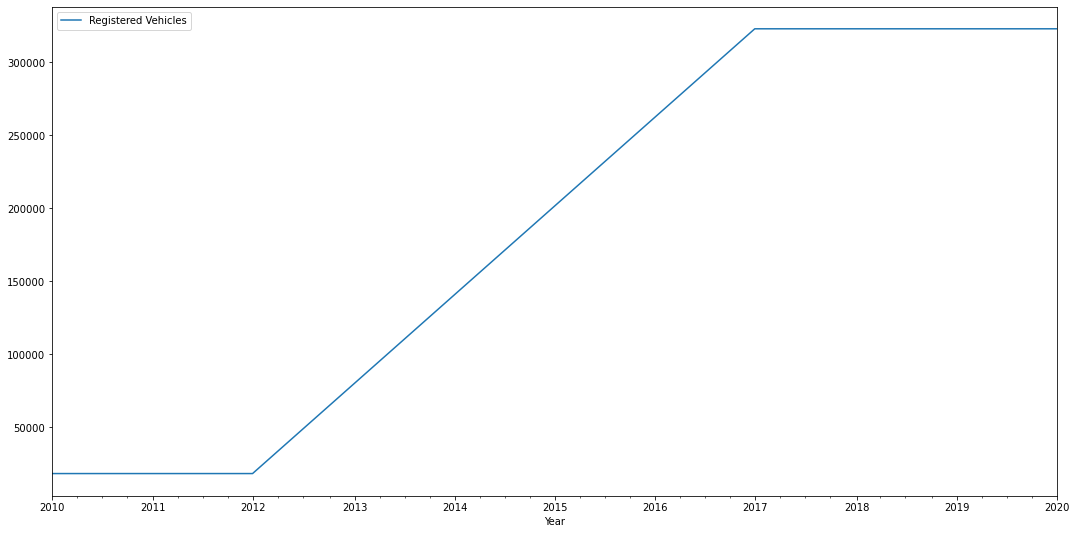

In [15]:
# Interpolate - Backfill 
df = df.resample('W').interpolate(method = 'linear')
df = df.bfill()
print(df.head())
df.plot()
df

In [ ]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

In [ ]:
# #Frontfill 
# df = df.resample('M').ffill()
# df.plot()

## Testing 

In [7]:
adtest = adfuller(df)
display(adtest)

(-1.9371440235526576,
 0.3147941109023367,
 1,
 521,
 {'1%': -3.4429638415440995,
  '5%': -2.867103482127635,
  '10%': -2.569733131582922},
 5750.818376441284)

## Modeling

In [8]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2010':'2018']
test = df['2019':'2020']
combined = df

test

,Registered Vehicles
Year,
2019-01-06,322762.0
2019-01-13,322762.0
2019-01-20,322762.0
2019-01-27,322762.0
2019-02-03,322762.0
2019-02-10,322762.0
2019-02-17,322762.0
2019-02-24,322762.0
2019-03-03,322762.0


In [10]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12850.876, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7122.094, Time=0.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5433.540, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5435.549, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5435.539, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6692.164, Time=0.45 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5432.793, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7123.355, Time=0.39 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=5434.750, Time=0.57 

### The best model is :  ARIMA (2,0,1) (0,0,0) [0]

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9979      0.100     19.965      0.000       1.802       2.194
ar.L2         -0.9980      0.100     -9.938      0.000      -1.195      -0.801
ma.L1         -0.0006      1.084     -0.001      1.000      -2.125       2.124
sigma2      5822.8302     79.328     73.402      0.000    5667.350    5978.310


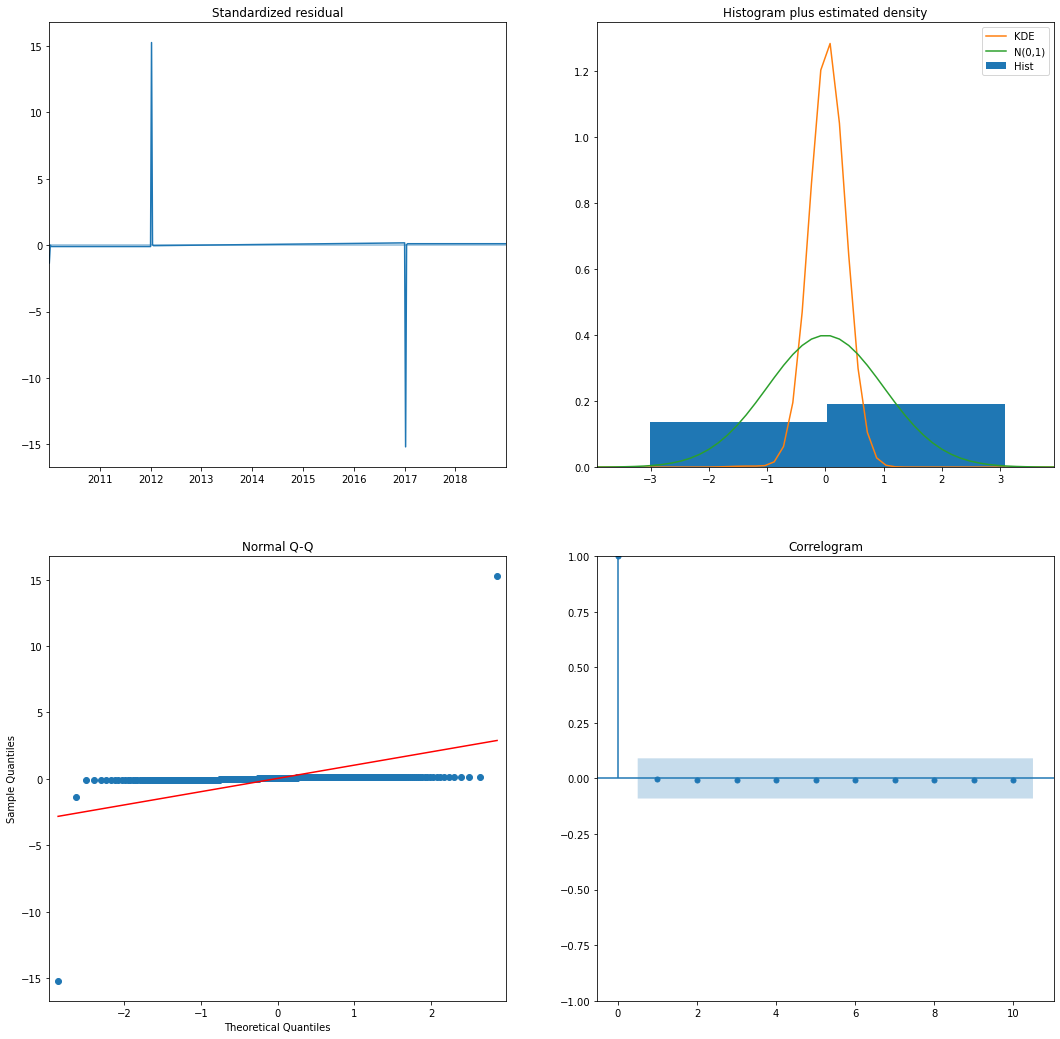

In [11]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [12]:
pred = output.get_prediction(start=pd.to_datetime('2019-01-06'), end=pd.to_datetime('2020-01-05'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2019-01-06,322608.506938,322907.626729
2019-01-13,322416.134719,323084.286866
2019-01-20,322179.921652,323296.958300
2019-01-27,321905.862192,323539.662834
2019-02-03,321598.003283,323808.369844
2019-02-10,321259.280428,324100.160211
2019-02-17,320891.945809,324412.798196
2019-02-24,320497.798937,324744.500791
2019-03-03,320078.321816,325093.802560
2019-03-10,319634.763766,325459.470807


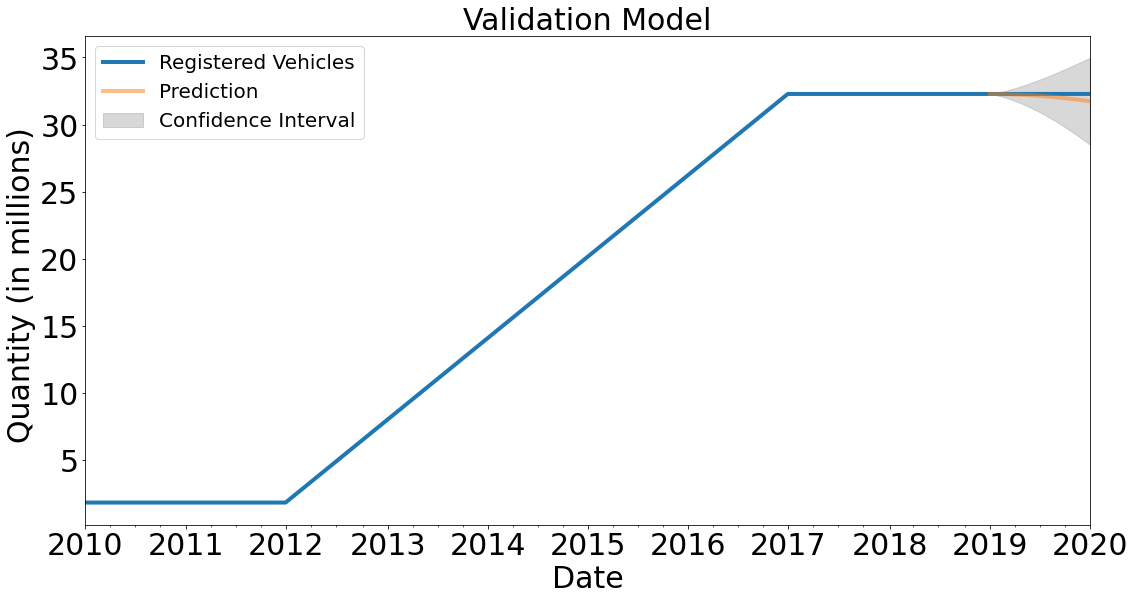

In [14]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()